## EDA of this insurance dataset



the numeric features are Index(['Age', 'Annual Income', 'Health Score', 'Vehicle Age', 'Credit Score'], dtype='object')
the category features are Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type',
       'Number of Dependents', 'Previous Claims', 'Insurance Duration'],
      dtype='object')


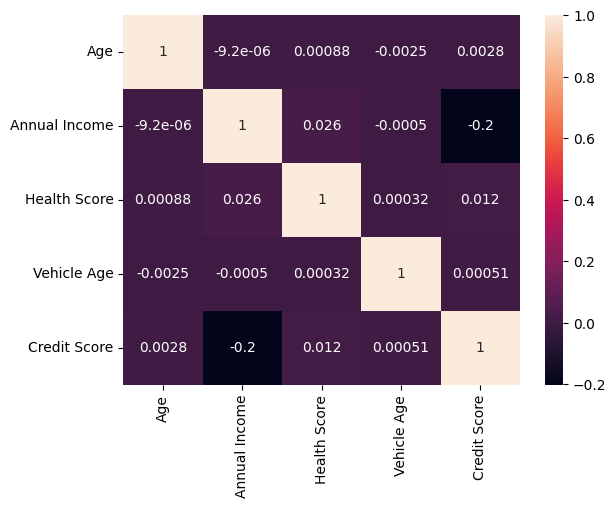

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import plotly.express as px



# mpl.rcParams['agg.path.chunksize'] = 10000  # 根据需要调整数值

# # 可选：增加 path.simplify_threshold
# mpl.rcParams['path.simplify_threshold'] = 0.15  # 根据需要调整数值

# Load the data
df = pd.read_csv('data/train.csv')
# print(df['Insurance Duration'].unique())

numeric_features = df.select_dtypes(include=[np.number]).drop(['Number of Dependents', 'Previous Claims','Insurance Duration','Premium Amount','id'], axis=1)
# visualizing the numeric features for their distribution
# for i, col in enumerate(numeric_features.columns):
#     plt.figure(i)
#     plt.hist(numeric_features[col])
#     plt.title(col)
# plt.show()

category_features = df.select_dtypes(include=[object])
another_columns = ['Number of Dependents', 'Previous Claims','Insurance Duration']
category_features = pd.concat([category_features, df[another_columns]], axis=1)
# category_features.head()

print(f"the numeric features are {numeric_features.columns}")
print(f"the category features are {category_features.columns}")


# we corrplot to see the correlation between the numeric features
corr = numeric_features.corr()
sns.heatmap(corr, annot=True)
plt.show()


# then I want to check every column in numeric features, use pivot_table to see the satistics with target variable
# for col in numeric_features.columns:
#     print(df.pivot_table(index=col, values='Premium Amount', aggfunc='mean').sort_values('Premium Amount', ascending=True))



# for i in category_features.columns:
#     print(df.pivot_table(index=i, values='Premium Amount', aggfunc='mean').sort_values('Premium Amount', ascending=True))

# for i in category_features.columns:
#     sns.barplot(x=category_features[i].value_counts().index, y=category_features[i].value_counts()).set_title(i)
#     plt.show()

# Then, I check the correlation between the policy start date and the target variable

## Feature engineering

#### 1. deal with time series data, also I will add several new features for time series data(provide the wide info to the model) etc.
- year,Quarter,month,

#### 2. deal with the nan value, I will use different ways to fill the nan value for different columns

#### 3. deal with the categorical data, I will use the one-hot encoding to deal with the categorical data or use the label encoding to deal with the categorical data

#### 4. deal with the outliers, I will use the IQR method to deal with the outliers

#### 5. deal with the skewness, I will use the log transformation to deal with the skewness

#### 6. deal with the feature selection, I will use the feature importance to select the important features

#### 7. deal with the scaling, I will use the standard scaling to scale the data, divide data into scaled data and unscaled data


In [2]:
# deal with the policy start date
# First, we need to convert the policy start date to datetime format, only contain the year,month and day
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date']).dt.date
dategroup = df.groupby('Policy Start Date').agg({'Premium Amount':'mean'}).reset_index()
print(dategroup.head())




# draw the time series plot for the policy start date and target variable


## 3 use plotly to draw the time series plot
dategroup['Policy Start Date'] = dategroup['Policy Start Date'].astype(str)
fig = px.line(dategroup, x='Policy Start Date', y='Premium Amount')
fig.show()

  Policy Start Date  Premium Amount
0        2019-08-17     1217.622754
1        2019-08-18     1177.275290
2        2019-08-19     1162.078498
3        2019-08-20     1170.320988
4        2019-08-21     1190.803738


In [ ]:
df['Policy Start year'] = pd.to_datetime(df['Policy Start Date']).dt.year
df['Policy Start month'] = pd.to_datetime(df['Policy Start Date']).dt.month
df['Policy Start Quarter'] = pd.to_datetime(df['Policy Start Date']).dt.quarter

# print(df['Policy Start year'].unique())
# print(df['Policy Start month'].unique())
# print(df['Policy Start Quarter'].unique())

# imputation method
def Polynomial_interpolation(df, column):
    df[column] = df[column].interpolate(method='polynomial', order=2)
    return df

    


# deal with the nan and missing values
print(df.isnull().sum())
have_nan_columns = df.columns[df.isnull().any()]
print(have_nan_columns)

# 首先需要观察缺失属于哪种类型，是随机缺失还是有规律的缺失
# 如果是随机缺失，可以使用均值，中位数，众数填充
# 如果是有规律的缺失，可以使用插值法填充


# 使用假设检验判断是不是MCAR
from scipy.stats import chi2_contingency, ttest_ind,chi2
from sklearn.impute import KNNImputer, 

# for numerical features
def check_mcar(df, column):
    mcar = True
    # H0: the missing values are missing completely at random
    if column in numeric_features:
        # use t-test to check the missing values
        missing = df[df[column].isnull()]['Premium Amount']
        non_missing = df[~df[column].isnull()]['Premium Amount']
        t, p = ttest_ind(missing, non_missing)
        if p < 0.05:
            print(f"the missing values in {column} are not missing completely at random")
            mcar = False
        else:
            print(f"the missing values in {column} are missing completely at random")
            mcar = True
            
    else:
        # use chi2 test to check the missing values
        cross_tab = pd.crosstab(df[column].isnull(), df['Premium Amount'])
        chi2, p, dof, ex = chi2_contingency(cross_tab)
        if p < 0.05:
            print(f"the missing values in {column} are not missing completely at random")
            mcar = False
        else:
            print(f"the missing values in {column} are missing completely at random")
            mcar = True
    return mcar


    
    




threshold = 10
for col in have_nan_columns:
    if df[col].isnull().sum() < threshold:
        df[col].fillna(df[col].mean(), inplace=False)
    else:
        # use Imputation to fill the missing values
        # first, check the missing values are MCAR or not
        mcar = check_mcar(df, col)
        if mcar:
            #means the missing values are MCAR, we use mean or median to fill the missing values
            df[col].fillna(df[col].mean(), inplace=True)
            
        else:
            # means the missing values are not MCAR,I am going to try serval methods to fill the missing values
            # first, we just use the knn to fill the missing values
            knn = KNNImputer(n_neighbors=2)
            df[col] = knn.fit_transform(df[col].values.reshape(-1,1))
            # then, we use the polynomial interpolation to fill the missing values

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
Policy Start year            0
Policy Start month           0
Policy Start Quarter         0
dtype: int64
Index(['Age', 'Annual Income', 'Marital Status', 'Number of Dependents',
       'Occupation', 'Health Score', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Customer Feedback'],
      dtype='object')
[19. 39. 2